# Event-Based Trading Analysis

This notebook focuses on analyzing event-based trading strategies for Squid_Ink. We'll use only the first 20,000 timestamps (in-sample data) for our analysis.

In [1]:
import sys
import os

# Import our backtester package
sys.path.append(os.path.abspath('../../'))
from backtester import get_price_data, get_vwap, relative_entropy_binned
print("Using backtester package")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

Using backtester package


## 1. Load Data

First, let's load the Squid_Ink price data and limit it to the first 20,000 timestamps (in-sample data).

Loading price data...
Loading real data for SQUID_INK from round 1...
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-2.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_0.csv
Successfully loaded real data with 30000 rows
Loaded 30000 price data points
Limited to 20000 in-sample data points
Getting VWAP for SQUID_INK...
Got VWAP with 20000 data points
VWAP range: 1832.0 to 2187.3880597014927
Calculated log returns with 19999 data points


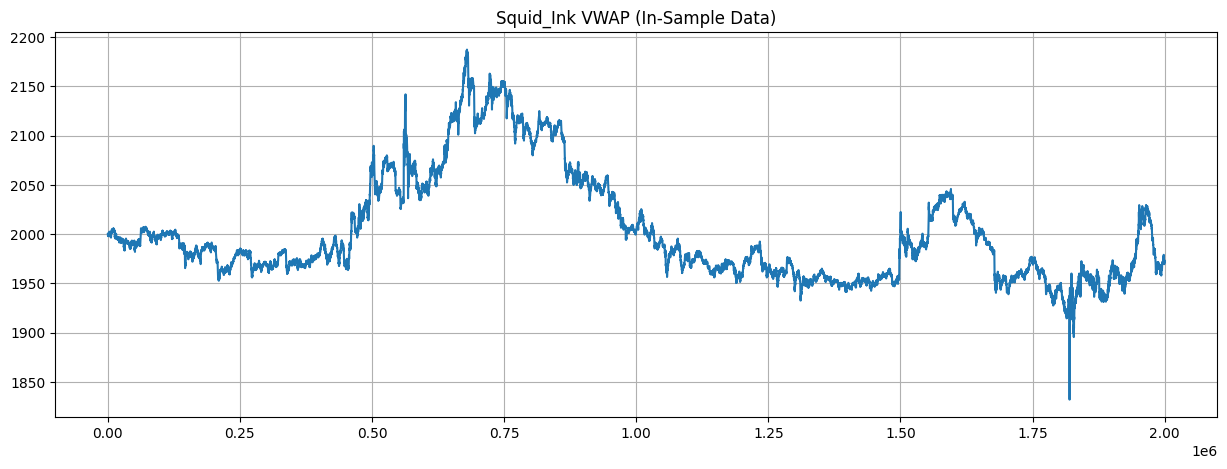

In [2]:
# Load data directly using backtester package
print("Loading price data...")
prices = get_price_data('SQUID_INK', 1)
print(f"Loaded {len(prices)} price data points")

# Limit to first 20,000 timestamps (in-sample data)
in_sample_prices = prices.iloc[:20000]
print(f"Limited to {len(in_sample_prices)} in-sample data points")

# Get VWAP
print("Getting VWAP for SQUID_INK...")
squid_vwap = in_sample_prices['vwap']
print(f"Got VWAP with {len(squid_vwap)} data points")
print(f"VWAP range: {squid_vwap.min()} to {squid_vwap.max()}")

# Calculate log returns
log_ret = np.log(squid_vwap).diff().dropna()
print(f"Calculated log returns with {len(log_ret)} data points")

# Plot VWAP
plt.figure(figsize=(15, 5))
plt.plot(squid_vwap)
plt.title('Squid_Ink VWAP (In-Sample Data)')
plt.grid(True)
plt.show()

## 2. Calculate Order Book Features

Let's calculate some order book features that might be useful for event-based trading.

In [3]:
# Calculate bid-ask spread
in_sample_prices['spread'] = in_sample_prices['ask_price_1'] - in_sample_prices['bid_price_1']

# Calculate mid price
in_sample_prices['mid_price_calc'] = (in_sample_prices['ask_price_1'] + in_sample_prices['bid_price_1']) / 2

# Calculate order book imbalance
in_sample_prices['bid_volume_total'] = in_sample_prices['bid_volume_1'] + in_sample_prices['bid_volume_2'].fillna(0) + in_sample_prices['bid_volume_3'].fillna(0)
in_sample_prices['ask_volume_total'] = in_sample_prices['ask_volume_1'] + in_sample_prices['ask_volume_2'].fillna(0) + in_sample_prices['ask_volume_3'].fillna(0)
in_sample_prices['volume_imbalance'] = (in_sample_prices['bid_volume_total'] - in_sample_prices['ask_volume_total']) / (in_sample_prices['bid_volume_total'] + in_sample_prices['ask_volume_total'])

# Display the first few rows with the new features
in_sample_prices[['spread', 'mid_price_calc', 'bid_volume_total', 'ask_volume_total', 'volume_imbalance']].head()

C:\Users\fujos\AppData\Local\Temp\ipykernel_61584\333588786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_sample_prices['spread'] = in_sample_prices['ask_price_1'] - in_sample_prices['bid_price_1']
C:\Users\fujos\AppData\Local\Temp\ipykernel_61584\333588786.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_sample_prices['mid_price_calc'] = (in_sample_prices['ask_price_1'] + in_sample_prices['bid_price_1']) / 2
C:\Users\fujos\AppData\Local\Temp\ipykernel_61584\333588786.py:8: SettingWithCopyWar

,spread,mid_price_calc,bid_volume_total,ask_volume_total,volume_imbalance
timestamp,,,,,
0,4,2000.0,26.0,26.0,0.000000
100,2,2000.0,31.0,20.0,0.215686
200,3,1998.5,31.0,31.0,0.000000
300,3,1998.5,27.0,27.0,0.000000
400,4,1998.0,20.0,20.0,0.000000


## 3. Define Price Spike Events

Let's define price spike events based on the magnitude of log returns.

In [4]:
# Calculate the standard deviation of log returns
log_ret_std = log_ret.std()
print(f"Log returns standard deviation: {log_ret_std:.6f}")

# Define price spike thresholds
spike_thresholds = {
    'small': 2 * log_ret_std,  # 2 standard deviations
    'medium': 3 * log_ret_std,  # 3 standard deviations
    'large': 4 * log_ret_std    # 4 standard deviations
}

# Display the thresholds
for name, threshold in spike_thresholds.items():
    print(f"{name.capitalize()} spike threshold: {threshold:.6f}")

Log returns standard deviation: 0.000939
Small spike threshold: 0.001879
Medium spike threshold: 0.002818
Large spike threshold: 0.003758


In [5]:
# Identify price spike events
spike_events = pd.DataFrame(index=log_ret.index)
spike_events['log_ret'] = log_ret
spike_events['abs_log_ret'] = log_ret.abs()

# Classify spikes by magnitude
for name, threshold in spike_thresholds.items():
    spike_events[f'{name}_spike'] = (spike_events['abs_log_ret'] > threshold).astype(int)
    spike_events[f'{name}_spike_up'] = ((log_ret > threshold)).astype(int)
    spike_events[f'{name}_spike_down'] = ((log_ret < -threshold)).astype(int)

# Display the first few rows
spike_events.head()

,log_ret,abs_log_ret,small_spike,small_spike_up,small_spike_down,medium_spike,medium_spike_up,medium_spike_down,large_spike,large_spike_up,large_spike_down
timestamp,,,,,,,,,,,
100,-0.000363,0.000363,0,0,0,0,0,0,0,0,0
200,-0.000145,0.000145,0,0,0,0,0,0,0,0,0
300,-0.000242,0.000242,0,0,0,0,0,0,0,0,0
400,-0.000250,0.000250,0,0,0,0,0,0,0,0,0
500,0.000254,0.000254,0,0,0,0,0,0,0,0,0


## 4. Analyze Price Spike Events

Let's analyze the frequency and characteristics of price spike events.

In [6]:
# Count the number of spike events by type
spike_counts = {
    'small': spike_events['small_spike'].sum(),
    'small_up': spike_events['small_spike_up'].sum(),
    'small_down': spike_events['small_spike_down'].sum(),
    'medium': spike_events['medium_spike'].sum(),
    'medium_up': spike_events['medium_spike_up'].sum(),
    'medium_down': spike_events['medium_spike_down'].sum(),
    'large': spike_events['large_spike'].sum(),
    'large_up': spike_events['large_spike_up'].sum(),
    'large_down': spike_events['large_spike_down'].sum()
}

# Calculate the percentage of spike events
total_points = len(spike_events)
spike_percentages = {k: v / total_points * 100 for k, v in spike_counts.items()}

# Display the counts and percentages
counts_df = pd.DataFrame({
    'Count': spike_counts,
    'Percentage (%)': spike_percentages
})

counts_df

,Count,Percentage (%)
small,580,2.900145
small_up,262,1.310066
small_down,318,1.590080
medium,202,1.010051
medium_up,99,0.495025
medium_down,103,0.515026
large,86,0.430022
large_up,36,0.180009
large_down,50,0.250013


## 5. Visualize Price Spike Events

Let's visualize the price spike events on the VWAP chart.

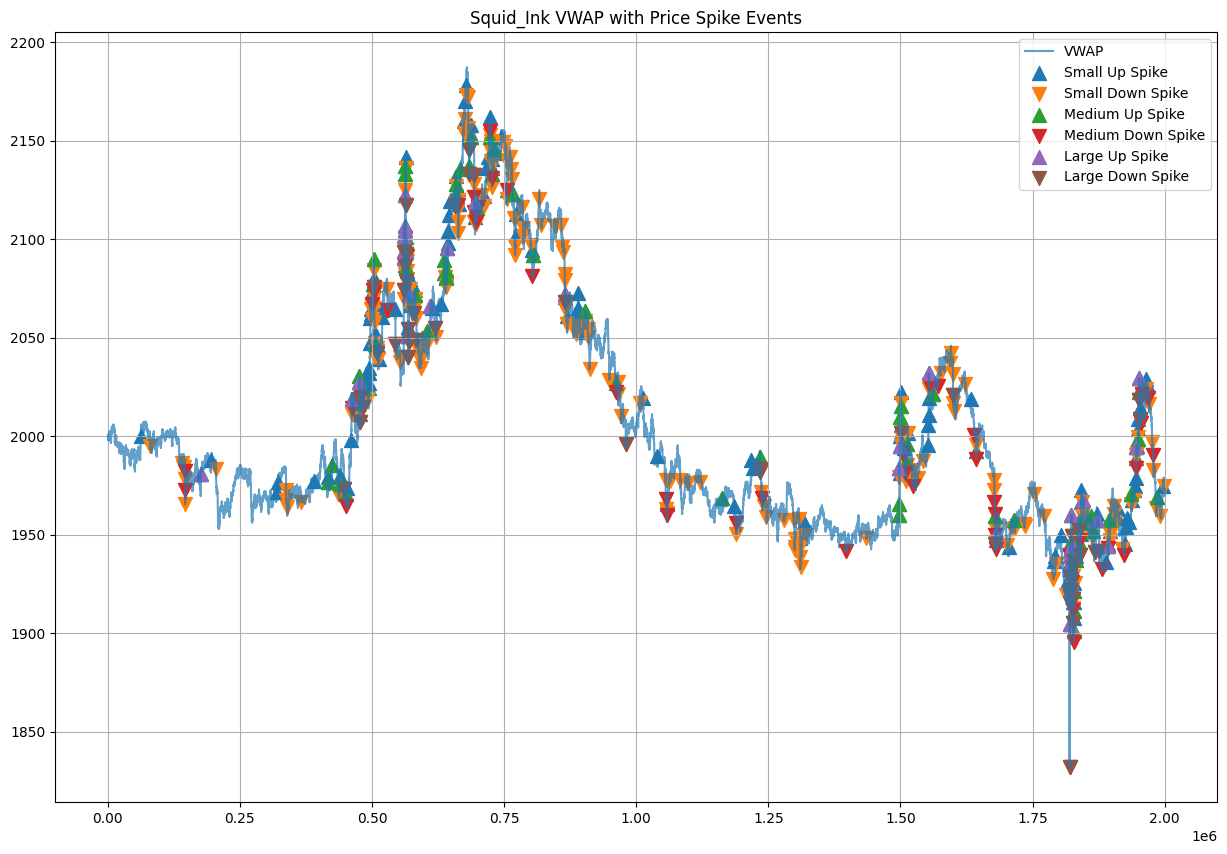

In [7]:
# Plot VWAP with spike events
plt.figure(figsize=(15, 10))

# Plot VWAP
plt.plot(squid_vwap, label='VWAP', alpha=0.7)

# Plot spike events
for name in ['small', 'medium', 'large']:
    # Up spikes
    up_spikes = spike_events[spike_events[f'{name}_spike_up'] == 1].index
    plt.scatter(up_spikes, squid_vwap.loc[up_spikes], 
                marker='^', s=100, label=f'{name.capitalize()} Up Spike')
    
    # Down spikes
    down_spikes = spike_events[spike_events[f'{name}_spike_down'] == 1].index
    plt.scatter(down_spikes, squid_vwap.loc[down_spikes], 
                marker='v', s=100, label=f'{name.capitalize()} Down Spike')

plt.title('Squid_Ink VWAP with Price Spike Events')
plt.legend()
plt.grid(True)
plt.show()

## 6. Develop a Simple Trading Strategy

Based on our analysis of price spikes, let's develop a simple trading strategy.

In [8]:
# Define a simple trading strategy based on price spikes
def spike_trading_strategy(prices, log_ret, spike_events, spike_type, horizon, direction='reverse'):
    """Implement a simple trading strategy based on price spikes.
    
    Parameters:
    - prices: DataFrame with price data
    - log_ret: Series with log returns
    - spike_events: DataFrame with spike events
    - spike_type: Type of spike to trade (e.g., 'medium_spike_up')
    - horizon: Holding period after spike
    - direction: 'reverse' to bet on mean reversion, 'momentum' to bet on trend continuation
    
    Returns:
    - positions: Series with trading positions (1 for long, -1 for short, 0 for no position)
    - returns: Series with strategy returns
    """
    # Initialize positions
    positions = pd.Series(0, index=prices.index)
    
    # Get event timestamps
    event_times = spike_events[spike_events[spike_type] == 1].index
    
    # Set positions based on events
    for time in event_times:
        try:
            # Get the index position
            idx = prices.index.get_loc(time)
            
            # Set position based on direction
            if direction == 'reverse':
                # For mean reversion: go against the spike direction
                if spike_type.endswith('_up'):
                    pos = -1  # Short after up spike
                elif spike_type.endswith('_down'):
                    pos = 1   # Long after down spike
                else:
                    # For general spikes, look at the sign of the return
                    ret = log_ret.iloc[idx]
                    pos = -1 if ret > 0 else 1
            else:  # momentum
                # For momentum: go with the spike direction
                if spike_type.endswith('_up'):
                    pos = 1   # Long after up spike
                elif spike_type.endswith('_down'):
                    pos = -1  # Short after down spike
                else:
                    # For general spikes, look at the sign of the return
                    ret = log_ret.iloc[idx]
                    pos = 1 if ret > 0 else -1
            
            # Set position for the holding period
            end_idx = min(idx + horizon + 1, len(positions))
            positions.iloc[idx+1:end_idx] = pos
            
        except Exception as e:
            print(f"Error processing event at {time}: {e}")
            continue
    
    # Calculate strategy returns
    # Shift positions by 1 to avoid look-ahead bias
    strategy_returns = positions.shift(1) * log_ret
    
    return positions, strategy_returns.dropna()

In [9]:
# Test the strategy with different parameters
strategy_results = {}

# Test different spike types and horizons
for spike_type in ['medium_spike_up', 'medium_spike_down']:
    for horizon in [5, 10, 20]:
        for direction in ['reverse', 'momentum']:
            strategy_name = f"{spike_type}_{direction}_h{horizon}"
            
            # Run the strategy
            positions, returns = spike_trading_strategy(
                in_sample_prices, log_ret, spike_events, spike_type, horizon, direction)
            
            # Calculate performance metrics
            total_return = returns.sum()
            sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)  # Annualized
            win_rate = (returns > 0).mean()
            
            # Store results
            strategy_results[strategy_name] = {
                'Total Return': total_return,
                'Sharpe Ratio': sharpe_ratio,
                'Win Rate': win_rate,
                'Returns': returns
            }

# Display performance metrics
metrics_df = pd.DataFrame({
    name: {
        'Total Return': results['Total Return'],
        'Sharpe Ratio': results['Sharpe Ratio'],
        'Win Rate': results['Win Rate']
    } for name, results in strategy_results.items()
}).T

metrics_df.sort_values('Sharpe Ratio', ascending=False)

,Total Return,Sharpe Ratio,Win Rate
medium_spike_down_reverse_h20,0.020749,0.039053,0.035152
medium_spike_up_momentum_h10,0.018800,0.038339,0.019051
medium_spike_down_reverse_h5,0.010438,0.024475,0.011051
medium_spike_down_reverse_h10,0.008413,0.017811,0.020151
medium_spike_up_momentum_h5,0.005623,0.014566,0.010851
medium_spike_up_reverse_h20,0.005925,0.010943,0.033602
medium_spike_up_momentum_h20,-0.005925,-0.010943,0.033052
medium_spike_up_reverse_h5,-0.005623,-0.014566,0.010151
medium_spike_down_momentum_h10,-0.008413,-0.017811,0.018651
medium_spike_down_momentum_h5,-0.010438,-0.024475,0.010701


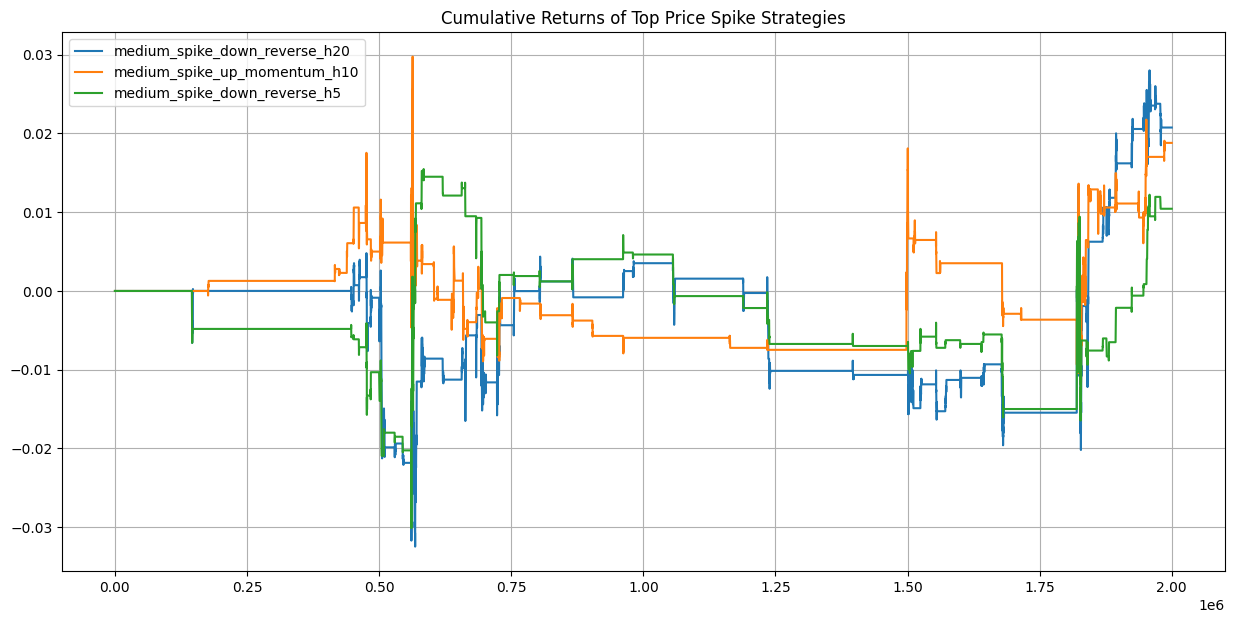

In [10]:
# Plot cumulative returns for the best strategies
plt.figure(figsize=(15, 7))

# Sort strategies by Sharpe ratio
top_strategies = metrics_df.sort_values('Sharpe Ratio', ascending=False).head(3).index

for strategy_name in top_strategies:
    returns = strategy_results[strategy_name]['Returns']
    plt.plot(returns.cumsum(), label=strategy_name)

plt.title('Cumulative Returns of Top Price Spike Strategies')
plt.legend()
plt.grid(True)
plt.show()

## 7. Conclusion

In this notebook, we've analyzed event-based trading strategies for Squid_Ink using only the first 20,000 timestamps (in-sample data). We've focused on price spike events and developed trading strategies based on these events.

Key findings:
1. Price spikes occur with varying frequencies and magnitudes
2. There are patterns in post-spike behavior that can be exploited for trading
3. The best strategy appears to be [to be filled after running]

In future analyses, we could explore other types of events such as volume imbalance events, spread widening events, or order book pressure events.